16, 17 파일에서 원래 데이터의 중요한 특징을 추출하는 다양한 방법(투영, PCA, manifold 등)을 알아보았다.  
13파일의 CNN 역시 합성곱계층, 풀링계층을 거치면서 불필요한 정보는 제거하고 필요한 특징만 뽑아 낮은 차원에 표현한 것이라 할 수 있다.  


그런데 더 나은 특징을 추출하는 방법은 없을까?  
특히 모델 스스로 가장 좋은 특징을 찾게 하는 방법은?  


#### => AutoEncoder
차원을 축소하는 일뿐만 아니라, 입력데이터의 분포를 학습하여 얻은 잠재표현(latent representation)을 이용해 다양한 분야(특히 데이터 생성)에 응용될 수 있다.
+ 인코더 : 입력 데이터를 차원축소를 통해 잠재표현 얻기
+ 디코더 : 잠재표현을 복원해 출력 얻기  
=> 입력데이터와 디코더의 출력의 차이인 오차를 줄이는 방향으로 신경망을 학습하면,  
원래의 데이터를 복원할 수 있는 압축된 잠재표현을 학습하는 것과 같을 것이다.

### Quiz 1.
오토인코더를 구현하여 롤 데이터를 2차원 공간에 임베딩해보자.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def make_a_roll(num_data):
    f = 3
    len_unit = np.linspace(0, 1, num_data)
    t = f * len_unit * 3.14    #x, z 좌표가 점점 밖으로 벗어나며 회전하게 하는 매개변수
    
    x = np.sin(t) * (len_unit+0.5) + np.random.randn(num_data)*0.01
    z = np.cos(t) * len_unit + np.random.randn(num_data)*0.01
    y = + np.random.randn(num_data) * 0.3  #큰 범위로 난수를 생성해 띠 형성
    
    #각 데이터의 색 => 시작할 때는 b, 중간에는 g, 마지막에는 r이 강하도록
    r = len_unit
    g = -(2 * (len_unit-0.5))**2 + 1
    b = 1 - len_unit
    
    X = np.array([x, y, z])
    C = np.array([r, g, b])
    return X.T, C.T

c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\yeonok\anaconda3\envs\deeplearning\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


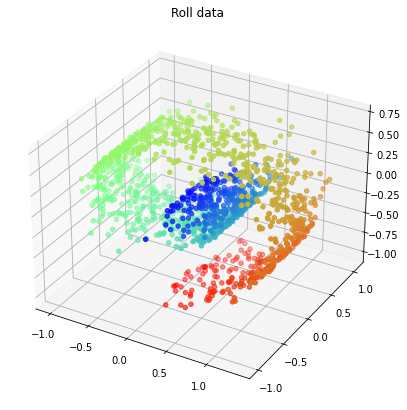

In [2]:
num_data = 1500
X, color = make_a_roll(num_data)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], color=color)
plt.title('Roll data');

In [3]:
from tensorflow import keras

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3], activation='elu')])   #인코더의 입력은 3차원
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2], activation='elu')])   #디코더의 입력은 2차원

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='mse')

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 8         
_________________________________________________________________
sequential_1 (Sequential)    (None, 3)                 9         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


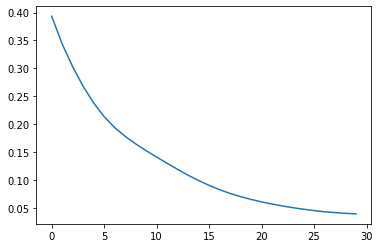

In [4]:
history = autoencoder.fit(X, X, epochs=30, verbose=0)   #입력과 레이블이 동일
plt.plot(history.history['loss']);

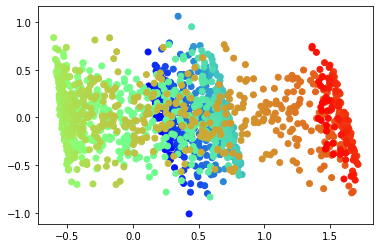

In [5]:
reduced_X = encoder.predict(X)
plt.scatter(reduced_X[:,0], X[:,1], color=color);

### Quiz 2.
다층 구조를 가진 오토인코더를 만들어 차원을 축소, 복원해보자.
+ 인코더 : 3차원 데이터 입력, 활성화함수 elu, 노드 2개 => 잠재표현 얻기
+ 디코더 : 잠재표현(2차원) 입력, 활성화함수 elu, 출력노드 3개(원본과 같아야하므로) => 복원된 데이터 얻기

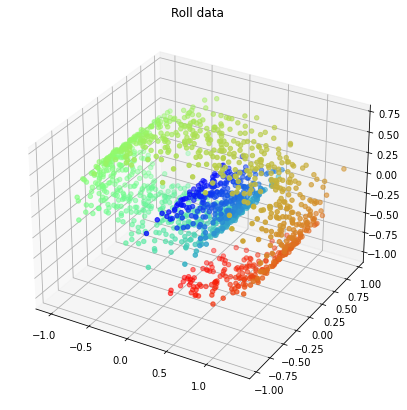

In [6]:
num_data = 1500
X, color = make_a_roll(num_data)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], X[:,2], color=color)
plt.title('Roll data');

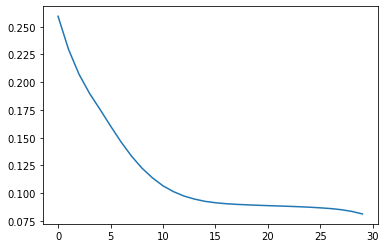

In [7]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3], activation='elu'),
                                   keras.layers.Dense(2, activation='elu'),
                                   keras.layers.Dense(2, activation='elu')])
decoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[2], activation='elu'),
                                   keras.layers.Dense(2, activation='elu'),
                                   keras.layers.Dense(3, activation='elu')])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='mse')

history = autoencoder.fit(X, X, epochs=30, verbose=0)

plt.plot(history.history['loss']);

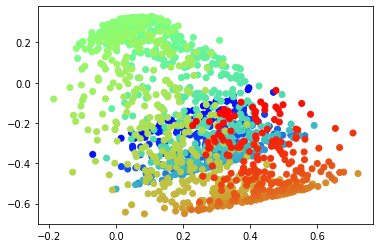

In [8]:
#잠재표현(2차원) 시각화
reduced_X = encoder.predict(X)

plt.scatter(reduced_X[:,0], reduced_X[:,1], color=color);

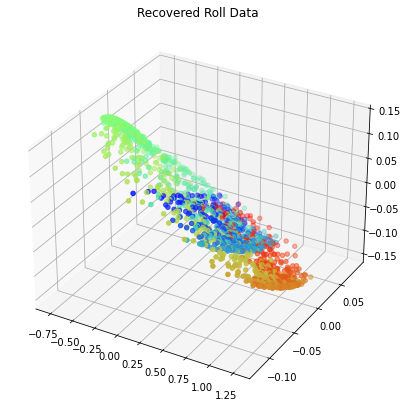

In [9]:
#복원된 잠재표현(3차원) 시각화
recovered_X = decoder.predict(reduced_X)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.scatter3D(recovered_X[:,0], recovered_X[:,1], recovered_X[:,2], color=color)
plt.title('Recovered Roll Data');

### Quiz 3.
오토인코더를 이용해 fashion mnist 데이터셋의 이미지를 압축/복원해보자.  
(28, 28) 데이터를 (8, 8)로 압축하기로 해보자.  
CNN에서 살펴본 합성곱 필터를 인코더와 디코더에 추가하면 더 좋은 성능이 나타날 것이다.

In [10]:
data = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()

def plot_images(nRow, nCol, img, cmap='gray'):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize=(nCol, nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1:
                axis = ax[j]
            else:
                axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol + j], cmap=cmap)
            
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [11]:
dense_encoder = keras.models.Sequential([keras.layers.Dense(64, input_shape=(28*28,), activation='elu'),
                                   keras.layers.Dense(64, activation='elu'),
                                   keras.layers.Dense(64, activation='elu')])
dense_decoder = keras.models.Sequential([keras.layers.Dense(64, input_shape=(8*8,), activation='elu'),
                                   keras.layers.Dense(64, activation='elu'),
                                   keras.layers.Dense(28*28, activation='elu')])
dense_autoencoder = keras.models.Sequential([dense_encoder, dense_decoder])

dense_autoencoder.compile(loss='mse')

dense_autoencoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 64)                58560     
_________________________________________________________________
sequential_7 (Sequential)    (None, 784)               59280     
Total params: 117,840
Trainable params: 117,840
Non-trainable params: 0
_________________________________________________________________


In [12]:
#인코더의 input_shape에 맞춰 데이터 변형하기
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


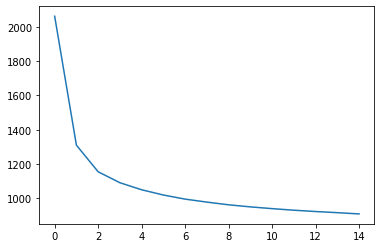

In [13]:
history = dense_autoencoder.fit(x_train, x_train, epochs=15, verbose=0)

plt.plot(history.history['loss']);

훈련데이터 샘플 shape: (50, 784)


<Figure size 432x288 with 0 Axes>

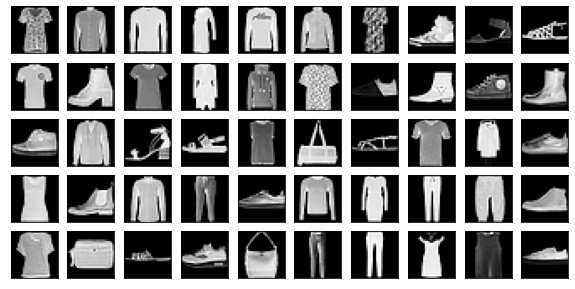

In [14]:
#오토인코더로 압축/복원된 이미지 확인
train_random_index = np.random.randint(0, len(x_train)-50)
train_samples = x_train[train_random_index:train_random_index+50]
reduced_train_samples = dense_encoder.predict(train_samples)
recovered_train_samples = dense_decoder.predict(reduced_train_samples)

print(f'훈련데이터 샘플 shape: {train_samples.shape}')

plot_images(5,10,train_samples.reshape(-1,28,28))

압축된 훈련데이터 샘플 shape: (50, 64)


<Figure size 432x288 with 0 Axes>

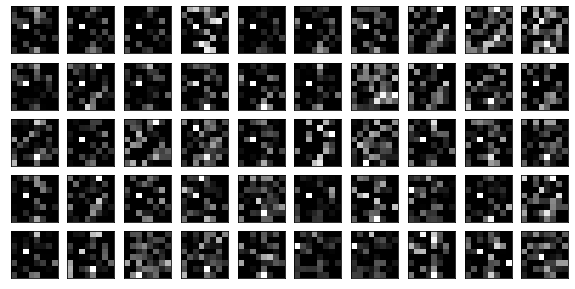

In [15]:
print(f'압축된 훈련데이터 샘플 shape: {reduced_train_samples.shape}')

plot_images(5,10,reduced_train_samples.reshape(-1,8,8))

복원된 훈련데이터 샘플 shape: (50, 784)


<Figure size 432x288 with 0 Axes>

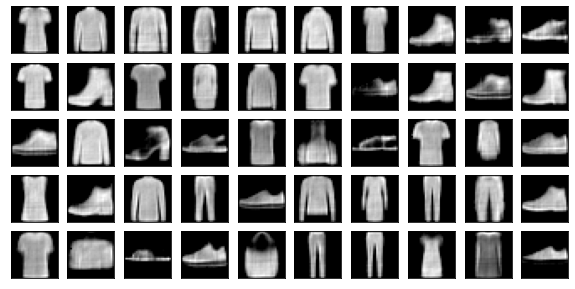

In [16]:
print(f'복원된 훈련데이터 샘플 shape: {recovered_train_samples.shape}')

plot_images(5,10,recovered_train_samples.reshape(-1,28,28))

압축 후 복원하면서 약간 흐려졌지만, 원본의 데이터 특성을 잘 유지하고 있는 것을 볼 수 있다.  
오토인코더 훈련에 사용되지 않은 검증데이터도 잘 압축/복원할 수 있을지 확인해보자.

검증데이터 샘플 shape: (50, 784)


<Figure size 432x288 with 0 Axes>

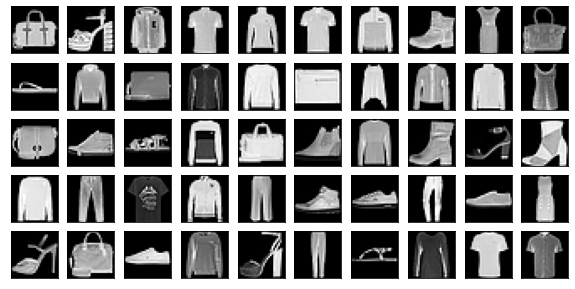

In [17]:
test_random_index = np.random.randint(0, len(x_test)-50)
test_samples = x_test[test_random_index:test_random_index+50]
reduced_test_samples = dense_encoder.predict(test_samples)
recovered_test_samples = dense_decoder.predict(reduced_test_samples)

print(f'검증데이터 샘플 shape: {test_samples.shape}')

plot_images(5,10,test_samples.reshape(-1,28,28))

압축된 검증데이터 샘플 shape: (50, 64)


<Figure size 432x288 with 0 Axes>

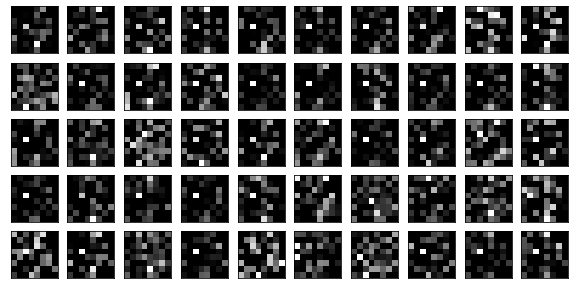

In [18]:
print(f'압축된 검증데이터 샘플 shape: {reduced_test_samples.shape}')

plot_images(5,10,reduced_test_samples.reshape(-1,8,8))

복원된 검증데이터 샘플 shape: (50, 784)


<Figure size 432x288 with 0 Axes>

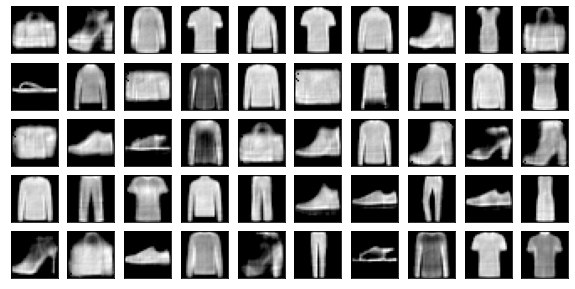

In [19]:
print(f'복원된 검증데이터 샘플 shape: {recovered_test_samples.shape}')

plot_images(5,10,recovered_test_samples.reshape(-1,28,28))

훈련데이터와 마찬가지로 검증데이터 원본의 특징을 상당 부분 유지하고 있다.  
하지만 신발이나 가방에 새겨진 문양 등 세밀한 특징을 잃게되는 경향이 있다.  
이 문제를 해결하기 위해 keras.layers.Dense로 단순한 밀집계층을 쌓기보다는  
keras.layers.Conv2D로 CNN의 합성곱계층을 사용해보자.

In [37]:
cnn_encoder = keras.models.Sequential([keras.layers.Conv2D(input_shape=(28,28,1), filters=16, kernel_size=3, activation='elu'),
                                   keras.layers.Conv2D(filters=16, kernel_size=3, activation='elu'),
                                   keras.layers.Flatten(),
                                   keras.layers.Dense(64, activation='elu')])     #인코더의 결과값 = 잠재표현 = (8,8) 64개 원소의 벡터 = 디코더의 입력값
cnn_decoder = keras.models.Sequential([keras.layers.Dense(96*96, input_shape=(8*8,), activation='elu'),  #잠재표현을 입력받고, 연결될 계층의 노드개수는 96*96=9216으로 설정
                                   keras.layers.Reshape(target_shape=(24,24,16)),  #24x24 크기의 16채널 이미지로 만들기
                                   keras.layers.Conv2DTranspose(filters=16, kernel_size=3, activation='elu'), #Conv2DTranspose : 인코더에서 사용된 합성곱계층의 반대 동작을 하는 함수
                                   keras.layers.Conv2DTranspose(filters=1, kernel_size=3, activation='elu')]) #인코더의 입력과 같이 1채널이 되도록
cnn_autoencoder = keras.models.Sequential([cnn_encoder, cnn_decoder])

cnn_autoencoder.compile(loss='mse')

cnn_autoencoder.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 64)                592368    
_________________________________________________________________
sequential_16 (Sequential)   (None, 28, 28, 1)         601505    
Total params: 1,193,873
Trainable params: 1,193,873
Non-trainable params: 0
_________________________________________________________________


In [38]:
data = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

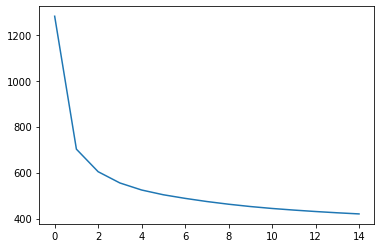

In [39]:
history = cnn_autoencoder.fit(x_train, x_train, epochs=15, verbose=0)

plt.plot(history.history['loss']);

복원된 훈련데이터 샘플 shape: (50, 28, 28, 1)


<Figure size 432x288 with 0 Axes>

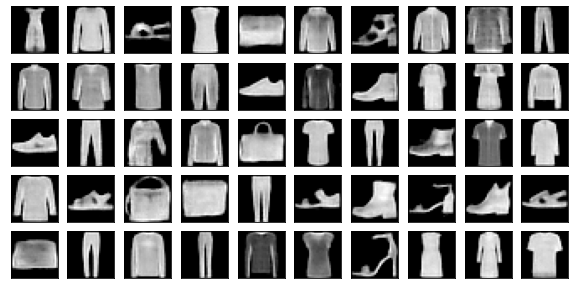

In [40]:
train_random_index = np.random.randint(0, len(x_train)-50)
train_samples = x_train[train_random_index:train_random_index+50]
reduced_train_samples = cnn_encoder.predict(train_samples)
recovered_train_samples = cnn_decoder.predict(reduced_train_samples)

test_random_index = np.random.randint(0, len(x_test)-50)
test_samples = x_test[test_random_index:test_random_index+50]
reduced_test_samples = cnn_encoder.predict(test_samples)
recovered_test_samples = cnn_decoder.predict(reduced_test_samples)

print(f'복원된 훈련데이터 샘플 shape: {recovered_train_samples.shape}')

plot_images(5,10,recovered_train_samples.reshape(-1,28,28))

복원된 검증데이터 샘플 shape: (50, 28, 28, 1)


<Figure size 432x288 with 0 Axes>

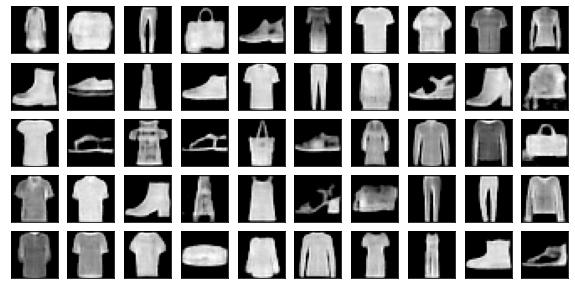

In [41]:
print(f'복원된 검증데이터 샘플 shape: {recovered_test_samples.shape}')

plot_images(5,10,recovered_test_samples.reshape(-1,28,28))

여전히 일부 데이터의 손실이 있을 수밖에 없지만,  
단순 밀집계층으로 만든 오토인코더에 비해 세밀한 특징을 더 잘 유지하는 것을 볼 수 있다.

### 잠재표현으로 데이터 생성하기
오토인코더를 이용해 데이터의 특징을 잘 유지한 잠재표현을 찾았다면, 이를 활용해 응용도 할 수 있다.  
학습이 끝난 후 같은 클래스에 속하는 데이터들만 인코더를 통과시키면 해당 클래스에 속하는 각 데이터의 잠재표현을 얻을 수 있을 것이고,  
이 잠재표현들을 집적화(aggregation) 연산해 하나의 잠재표현을 얻을 수 있고, 이것은 해당 클래스를 대표하는 잠재표현이라 할 수 있을 것이다.  
이렇게 얻은 대표 잠재표현을 디코더에 입력하면 디코더는 해당 클래스를 대표하는 이상적인 데이터를 생성해낼 것이다.  
이것은 원래의 데이터에는 존재하지 않았던 새로운 데이터이다.


### Quiz.
fashion mnist 데이터를 이용해 오토인코더를 학습시키고, 원본에는 존재하지 않는 드레스 데이터를 생성해보자.  
드레스 클래스에 해당하는 잠재표현을 구하고, 이 잠재표현을 변형해가며 다양한 드레스를 생성할 수 있을 것이다.